# Parte 1 — Investigación (PyTorch)

## 1) nn.Conv2d

i) Tipo de entrada
- Tensor 4D con forma (N, C, H, W): N = batch, C = canales, H = alto, W = ancho. Para MNIST: C=1.

ii) Parámetros principales (más usados)  
- in_channels, out_channels: canales de entrada/salida (número de filtros = out_channels).  
- kernel_size: tamaño del filtro (p. ej., 3, 5 o tupla (kh, kw)).  
- stride: paso del filtro (por defecto 1).  
- padding: relleno (p. ej., 0, 1, “same” en algunas APIs).  
- dilation: espaciamiento de elementos del kernel (para dilated convs).  
- groups: agrupa canales para grouped/depthwise conv.  
- bias: incluye término bias si True.

iii) Uso típico en CNN  
- Extracción jerárquica de características (bordes → formas → partes).  
- Se suele combinar con activación (ReLU) y pooling para reducir resolución preservando rasgos.  
- En MNIST, dos o tres bloques Conv2d + ReLU + Pool son un baseline muy eficaz.


## 2) nn.MaxPool2d

i) Tipo de entrada  
- Tensor 4D (N, C, H, W), misma convención que Conv2d.

ii) Parámetros principales  
- kernel_size: ventana de pooling.  
- stride: paso entre ventanas (si es None, usa kernel_size).  
- padding: relleno previo al pooling.  
- dilation: rate de muestreo dentro de la ventana (menos común).  
- return_indices: devuelve índices del máximo (útil para unpooling).  
- ceil_mode: usa ceil en lugar de floor para calcular la salida.

iii) Uso típico en CNN  
- Submuestreo que aporta invariancia a pequeñas traslaciones y reduce coste computacional.  
- Suele seguir a una o dos convoluciones (Conv2d → ReLU → MaxPool2d).


## 3) nn.AvgPool2d

i) Tipo de entrada  
- Tensor 4D (N, C, H, W), igual que las anteriores.

ii) Parámetros principales  
- kernel_size, stride, padding, ceil_mode: análogos a MaxPool2d.  
- count_include_pad: si cuenta el padding en el promedio.  
- divisor_override: divisor personalizado para el promedio.

iii) Uso típico en CNN  
- Alternativa a max-pooling cuando interesa suavizar o agregar información (p. ej., antes de capas densas).  
- Variante relacionada: AdaptiveAvgPool2d para forzar un tamaño de salida fijo (muy usada antes de fully-connected).

> Max vs Avg Pooling: Max destaca rasgos más fuertes (activa si “hay” una característica), Avg captura tendencia promedio; la elección depende del problema/datos.



## 4) Normalización del dataset MNIST

Objetivo  
- Estandarizar cada imagen a escala de media 0 y desviación 1 (por canal) para:  
  - estabilizar y acelerar la optimización,  
  - ayudar a la generalización (menos sensibilidad a escalas),  
  - reducir internal covariate shift.

Práctica recomendada con torchvision.transforms.Normalize  
- Para MNIST se usan comúnmente mean=(0.1307,) y std=(0.3081,), que son la media y desviación estándar empíricas del conjunto (en escala [0,1] tras ToTensor).  
- Pipeline típico:
  python
  transforms.Compose([
      transforms.ToTensor(),                     
      transforms.Normalize((0.1307,), (0.3081,))
  ])


# Parte 2 - Construcción de Red CNN para MNIST

En esta sección construiremos una red neuronal convolucional (CNN) en PyTorch que cumpla con las siguientes características:

- Entrada de imágenes 28x28 (dataset MNIST).
- Al menos 2 capas convolucionales (Conv2D).
- Al menos 2 capas de pooling (MaxPool2D).
- Capa de salida con 10 neuronas (una por cada dígito).
- Función de pérdida: CrossEntropyLoss.
- Se probarán distintos parámetros:
  - Número de neuronas en capas totalmente conectadas.
  - Diferentes optimizadores (SGD, Adam).
  - Variación de filtros en capas convolucionales.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU name:", torch.cuda.get_device_name(0))

# Transformaciones y dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Definición de la CNN
class CNN(nn.Module):
    def __init__(self, fc_neurons=128, conv1_filters=32, conv2_filters=64):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_filters, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(conv2_filters * 7 * 7, fc_neurons)
        self.fc2   = nn.Linear(fc_neurons, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Función de entrenamiento
def train_model(model, optimizer, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for images, labels in train_loader:
            # mover a GPU (usar non_blocking si tienes pin_memory=True)
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Función de evaluación
def test_model(model):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)  # <-- mover a GPU
        labels = labels.to(device, non_blocking=True)  # <-- mover a GPU
        output = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Experimentos
model1 = CNN(fc_neurons=128, conv1_filters=32, conv2_filters=64)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
print("Entrenando modelo con Adam...")
train_model(model1, optimizer1, epochs=5)
acc1 = test_model(model1)


model2 = CNN(fc_neurons=256, conv1_filters=16, conv2_filters=32)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
print("\nEntrenando modelo con SGD...")
train_model(model2, optimizer2, epochs=5)
acc2 = test_model(model2)

Using device: cuda
GPU name: Tesla T4


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.31MB/s]


Entrenando modelo con Adam...
Epoch 1/5, Loss: 0.1293
Epoch 2/5, Loss: 0.0410
Epoch 3/5, Loss: 0.0282
Epoch 4/5, Loss: 0.0215
Epoch 5/5, Loss: 0.0155
Test Accuracy: 99.09%

Entrenando modelo con SGD...
Epoch 1/5, Loss: 0.2028
Epoch 2/5, Loss: 0.0528
Epoch 3/5, Loss: 0.0361
Epoch 4/5, Loss: 0.0274
Epoch 5/5, Loss: 0.0206
Test Accuracy: 98.86%


# Parte 3 - Benchmark: CNN vs Baseline (Lab 2)

Comparacion entre Lab 2 y Lab 3:
- Línea base (Lab 2): MLP para MNIST.
- Modelo nuevo (Lab 3): mejor CNN entrenada.

Se responde:
- ¿Qué arquitectura rindió mejor en general?
- ¿Quién logró mayor accuracy por parámetro?
- Matrices de confusión multiclase para ambos y análisis de errores.

[MLP] Epoch 1/5 - loss=0.2387
[MLP] Epoch 2/5 - loss=0.1060
[MLP] Epoch 3/5 - loss=0.0746
[MLP] Epoch 4/5 - loss=0.0595
[MLP] Epoch 5/5 - loss=0.0483
Test accuracy: 97.57%
MLP params: 203,530 | test acc: 97.57%
Test accuracy: 99.09%
Test accuracy: 98.86%
>> Mejor CNN: CNN#1 (Adam, conv 32-64, FC=128) | params=421,642 | acc=99.09%
Modelo                         |       Params |     Acc | Acc / M params
------------------------------------------------------------------------
MLP (baseline)                 |      203,530 |  97.57% |         4.7939
CNN#1 (Adam, conv 32-64, FC=128) |      421,642 |  99.09% |         2.3501


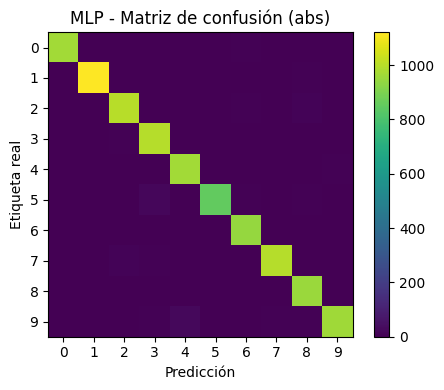

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

@torch.no_grad()
def evaluate_model(model, data_loader):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        preds = logits.argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())
    acc = correct / total
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
    print(f"Test accuracy: {acc*100:.2f}%")
    return acc, cm

def plot_confusion_matrix(cm, classes, title="Matriz de confusión", normalize=False):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True).clip(min=1)
    fig = plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.ylabel("Etiqueta real")
    plt.xlabel("Predicción")
    plt.tight_layout()
    plt.show()

# MLP baseline (Lab 2)
class MLP(nn.Module):
    def __init__(self, hidden=256, pdrop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(pdrop),
            nn.Linear(hidden, 10),
        )
    def forward(self, x):
        return self.net(x)

def train_loop(model, train_loader, optimizer, epochs=5):
    crit = nn.CrossEntropyLoss()
    model.to(device)
    model.train()
    for ep in range(1, epochs+1):
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = crit(out, yb)
            loss.backward()
            optimizer.step()
            running += loss.item()
        print(f"[MLP] Epoch {ep}/{epochs} - loss={running/len(train_loader):.4f}")

# Entrenar MLP baseline
mlp = MLP(hidden=256, pdrop=0.1)
opt_mlp = optim.Adam(mlp.parameters(), lr=1e-3)
train_loop(mlp, train_loader, opt_mlp, epochs=5)

mlp_params = count_params(mlp)
mlp_acc, mlp_cm = evaluate_model(mlp, test_loader)
print(f"MLP params: {mlp_params:,} | test acc: {mlp_acc*100:.2f}%")

model1 = model1.to(device)
model2 = model2.to(device)

acc_cnn1, cm_cnn1 = evaluate_model(model1, test_loader)
params_cnn1 = count_params(model1)

acc_cnn2, cm_cnn2 = evaluate_model(model2, test_loader)
params_cnn2 = count_params(model2)

if acc_cnn1 >= acc_cnn2:
    best_cnn, best_cnn_acc, best_cnn_cm, best_cnn_params, best_tag = model1, acc_cnn1, cm_cnn1, params_cnn1, "CNN#1 (Adam, conv 32-64, FC=128)"
else:
    best_cnn, best_cnn_acc, best_cnn_cm, best_cnn_params, best_tag = model2, acc_cnn2, cm_cnn2, params_cnn2, "CNN#2 (SGD, conv 16-32, FC=256)"

print(f">> Mejor CNN: {best_tag} | params={best_cnn_params:,} | acc={best_cnn_acc*100:.2f}%")

def per_million_params(acc, params):
    return acc / (params / 1_000_000)

rows = [
    ("MLP (baseline)", mlp_params, mlp_acc, per_million_params(mlp_acc, mlp_params)),
    (best_tag, best_cnn_params, best_cnn_acc, per_million_params(best_cnn_acc, best_cnn_params)),
]

print(f"{'Modelo':30} | {'Params':>12} | {'Acc':>7} | {'Acc / M params':>14}")
print("-" * 72)
for name, p, a, a_eff in rows:
    print(f"{name:30} | {p:12,d} | {a*100:6.2f}% | {a_eff:14.4f}")



classes = [str(i) for i in range(10)]
plot_confusion_matrix(mlp_cm, classes, title="MLP - Matriz de confusión (abs)", normalize=False)
plot_confusion_matrix(mlp_cm, classes, title="MLP - Matriz de confusión (normalizada)", normalize=True)

plot_confusion_matrix(best_cnn_cm, classes, title=f"{best_tag} - Matriz de confusión (abs)", normalize=False)
plot_confusion_matrix(best_cnn_cm, classes, title=f"{best_tag} - Matriz de confusión (normalizada)", normalize=True)

